## Does the month of the year impact scoring?

In the [Monthly Scoring EDA](./monthly-scoring-EDA.ipynb) notebook we explored the scoring trends by month for our scoring data set. In this notebook I will perform a permutation test on the 3 months of interest we identified. October, November and April.

Scoring in October and April seems to be up and November scores are lower. Here I will test if they are statistically higher or lower.

In [10]:
from data_utils import load_and_clean_games_data
games_df = load_and_clean_games_data()

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [12]:
seasons = games_df['season'].unique()
print(seasons)

['2008-2009' '2009-2010' '2010-2011' '2011-2012' '2013-2014' '2014-2015'
 '2015-2016' '2016-2017' '2017-2018' '2018-2019' '2021-2022' '2022-2023'
 '2023-2024' '2024-2025' '2025-2026']


In [13]:
#NHL Regular season October - April
month_order = [10, 11, 12, 1, 2, 3, 4]
#Function to calculate the difference in a given months goals per game
#minus the rest of the season.
#season is an optional parameter, otherwise it will be all time
def calculate_mean_diff_month(month: int, data: pd.DataFrame, season: str = "") -> float:
    month_data = data[data['month'] == month].copy()
    other_months_data = data[data['month'] != month].copy()
    if season:
        month_data = month_data[month_data['season'] == season]
        other_months_data = other_months_data[other_months_data['season'] == season]
    avg_goals_per_game_month = month_data['totalGoals'].mean()
    avg_goals_per_game_other_months = other_months_data['totalGoals'].mean()
    return avg_goals_per_game_month - avg_goals_per_game_other_months

## Permutation Test

In [14]:
#function for executing permutation test on a given month
#pass month and data to test
#return test_statistic, null_distribution, p_value
def run_permutation_test(month: int, data: pd.DataFrame):
    test_statistic = calculate_mean_diff_month(month, games_df)
    null_distribution = []
    for _ in range(10_000):
        #create copy
        data_replicate = data.copy()
        #shuffle
        data_replicate['month'] = np.random.permutation(data_replicate['month'].values)
        #calculate mean diff
        test_statistic_value = calculate_mean_diff_month(10, data_replicate)
        #add to simulation results
        null_distribution.append(test_statistic_value)
    #calculate P-value double sided p-test
    #p-value = # of times something as extreme as hypothesis occurs / sample size
    p_value = sum(abs(val) >= abs(test_statistic) for val in null_distribution) / len(null_distribution)
    return test_statistic, null_distribution, p_value

In [15]:
test_statistic_october, null_distribution_october, p_value_october = run_permutation_test(10, games_df)
print(f'Observed Difference: {test_statistic_october:.2f}\nP-value: {p_value_october:.3f}')

Observed Difference: 0.09
P-value: 0.077


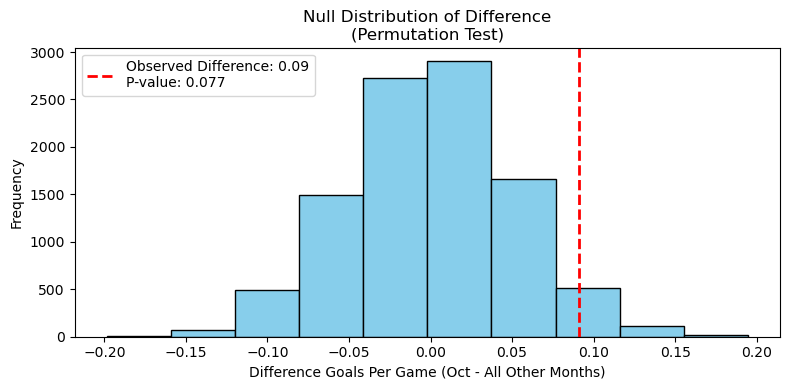

In [21]:
plt.figure(figsize=(8, 4))
plt.hist(null_distribution_october, color='skyblue', edgecolor='black')
plt.xlabel('Difference Goals Per Game (Oct - All Other Months)')
plt.ylabel('Frequency')
plt.title('Null Distribution of Difference\n(Permutation Test)')
plt.axvline(test_statistic_october, color='red', linestyle='dashed', linewidth=2, label=f'Observed Difference: {test_statistic_october:.2f}\nP-value: {p_value_october:.3f}')
plt.legend()
plt.tight_layout()
plt.savefig(f"results/October_Scoring_Permutation_Test.png", dpi=300)
plt.show()

## October does not have statistical significance. Does any other month?

The scoring in October isn't statistically significant (p=.074), thus we can reject our null hypothesis that scoring is up in the first month of the season. However, we identified in the [exploration of the data](./monthly-scoring-EDA.ipynb) that the scoring in November is the lowest and scoring is the highest in April. Let's see if either of those months have a statistical difference in scoring.

In [17]:

test_statistic_april, null_distribution_april, p_value_april = run_permutation_test(4, games_df)
print(f'Observed Difference: {test_statistic_april:.2f}\nP-value: {p_value_april:.3f}')

Observed Difference: 0.18
P-value: 0.000


In [18]:

test_statistic_nov, null_distribution_nov, p_value_nov = run_permutation_test(11, games_df)
print(f'Observed Difference: {test_statistic_nov:.2f}\nP-value: {p_value_nov:.3f}')

Observed Difference: -0.10
P-value: 0.052


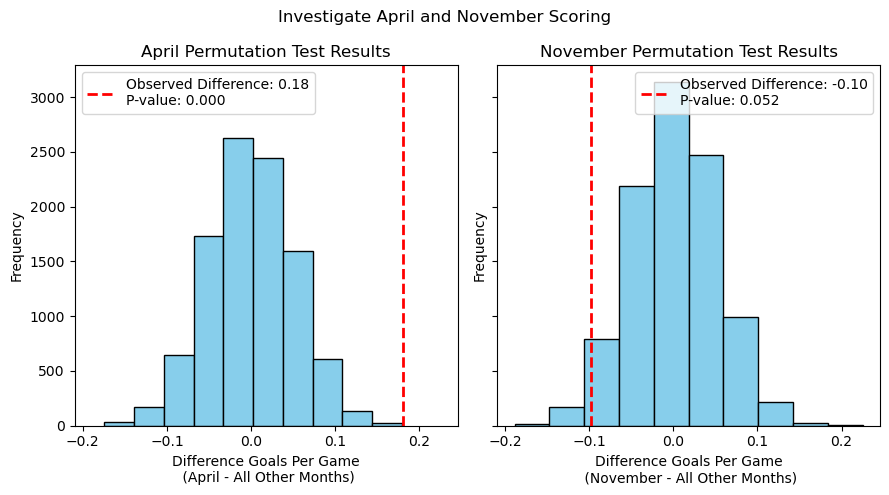

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True, sharex=True)
fig.suptitle("Investigate April and November Scoring")

# April
axes[0].hist(null_distribution_april, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Difference Goals Per Game\n (April - All Other Months)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('April Permutation Test Results')
axes[0].axvline(
    test_statistic_april,
    color='red',
    linestyle='dashed',
    linewidth=2,
    label=f'Observed Difference: {test_statistic_april:.2f}\nP-value: {p_value_april:.3f}'
)
axes[0].legend()

# November
axes[1].hist(null_distribution_nov, color='skyblue', edgecolor='black')
axes[1].set_xlabel('Difference Goals Per Game\n (November - All Other Months)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('November Permutation Test Results')
axes[1].axvline(
    test_statistic_nov,
    color='red',
    linestyle='dashed',
    linewidth=2,
    label=f'Observed Difference: {test_statistic_nov:.2f}\nP-value: {p_value_nov:.3f}'
)
axes[1].legend()

plt.tight_layout()
plt.savefig(f"results/April_Nov_Scoring_Permutation_Test.png", dpi=300)
plt.show()


## Conclusion

This test was inspired from the idea that it is good to "Hammer the over in October" because the logic is that the scoring is up the first month of the season and thus you can make money betting the score going over the first month of the season. I have proven here that this logic doesn't hold. There is no statistical significance to scoring in October. However, I have identified April as a month that scoring is statistically significantly higher and November as a month that scoring is statistically significantly lower! Maybe the logic should be "Hammer the under in November and the over in April"? I will explore this in the [Betting Simluations](./over-under-bootstrap-simulations.ipynb) notebook.